In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
os.listdir('data')

['AllNO2_QH.csv',
 'AllPM_QH.csv',
 'Env_QH.csv',
 'GradientTemp_15minDataSet.csv',
 'micro_sud3.pkl',
 'micro_sud3_normalized.pkl',
 'Patm_15minDataSet.csv',
 'pickles']

In [3]:
df = pd.read_pickle('data/micro_sud3_normalized.pkl')
df = df.reindex(np.random.permutation(df.index))
df = df.reset_index()

def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

def dataframe_to_xy(df, look_back):
    i = look_back
    while True:
        sequence = df.iloc[i - look_back:i]
        yield np.array(sequence[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                                 'tgrad', 'pressure', 'pluvio']]).reshape(look_back, 1, 8) , np.array(sequence['NO2_ref'])
        i += 1
        if i == len(df):
            i = look_back
            
def dataframe_to_xy_test(df, look_back):
    X_test, y_test = [], []
    i = look_back
    while i < len(df):
        sequence = df.iloc[i - look_back:i]
        X_test.append(np.array(sequence[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                                 'tgrad', 'pressure', 'pluvio']]).reshape(look_back, 1, 8))
        y_test.append(np.array(df.iloc[i]['NO2_ref']))
        i += 1
        if i == len(df):
            break
            
    return np.array(X_test), np.array(y_test)
            
        
df_test, df_train = split_dataframe(df, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

X_train = dataframe_to_xy(df_train, 10)
X_valid = dataframe_to_xy(df_valid, 10)
X_test, y_test = dataframe_to_xy_test(df_test, 10)

In [4]:
def dataframe_to_xy_no_generator(df, look_back):
    X, y = [], []
    i = look_back
    while i < len(df):
        sequence = df.iloc[i - look_back:i]
        X.append(np.array(sequence[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                                 'tgrad', 'pressure', 'pluvio']]).reshape(look_back, 1, 8))
        y.append(np.array(df.iloc[i]['NO2_ref']))
        i += 1
        if i == len(df):
            break
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], X.shape[3]))
    return X, y

In [5]:
X_train, y_train = dataframe_to_xy_no_generator(df_train, 24)
X_valid, y_valid = dataframe_to_xy_no_generator(df_valid, 24)
X_test, y_test = dataframe_to_xy_no_generator(df_test, 24)

In [6]:
from keras.layers import SimpleRNN, Dense, LSTM, GRU
from keras.models import Sequential
from keras.callbacks import EarlyStopping

def simple_rnn_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(nb_units, input_shape=input_dim))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def lstm_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(nb_units, input_shape=input_dim))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def gru_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(GRU(nb_units, input_shape=input_dim))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

In [7]:
model = simple_rnn_model(32, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1312      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________


In [8]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1 ,shuffle=False)

Train on 1103 samples, validate on 539 samples
Epoch 1/5000
1103/1103 [==============================] - 1s 528us/step - loss: 2586.4411 - val_loss: 2496.8802
Epoch 2/5000
1103/1103 [==============================] - 0s 145us/step - loss: 2499.1545 - val_loss: 2303.5566
Epoch 3/5000
1103/1103 [==============================] - 0s 142us/step - loss: 2096.0381 - val_loss: 1652.7320
Epoch 4/5000
1103/1103 [==============================] - 0s 138us/step - loss: 1456.1172 - val_loss: 1186.2553
Epoch 5/5000
1103/1103 [==============================] - 0s 164us/step - loss: 1180.1366 - val_loss: 1078.2868
Epoch 6/5000
1103/1103 [==============================] - 0s 155us/step - loss: 1131.2053 - val_loss: 1058.4533
Epoch 7/5000
1103/1103 [==============================] - 0s 156us/step - loss: 1103.8334 - val_loss: 1034.2973
Epoch 8/5000
1103/1103 [==============================] - 0s 134us/step - loss: 1075.7789 - val_loss: 1010.6394
Epoch 9/5000
1103/1103 [==============================] -

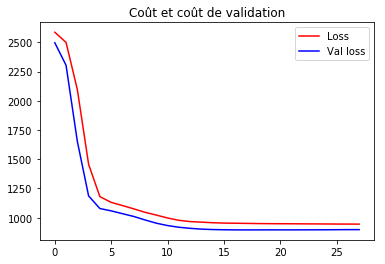

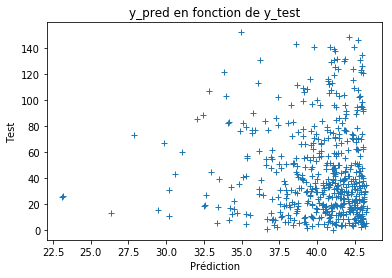

In [9]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [10]:
model = lstm_model(32, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5248      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 6,337
Trainable params: 6,337
Non-trainable params: 0
_________________________________________________________________


In [11]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

Train on 1103 samples, validate on 539 samples
Epoch 1/5000
1103/1103 [==============================] - 1s 1ms/step - loss: 2602.0669 - val_loss: 2512.1005
Epoch 2/5000
1103/1103 [==============================] - 0s 439us/step - loss: 2397.3056 - val_loss: 2046.6439
Epoch 3/5000
1103/1103 [==============================] - 0s 451us/step - loss: 1767.7182 - val_loss: 1377.6204
Epoch 4/5000
1103/1103 [==============================] - 0s 448us/step - loss: 1227.0696 - val_loss: 994.6922
Epoch 5/5000
1103/1103 [==============================] - 1s 455us/step - loss: 994.5223 - val_loss: 900.3121
Epoch 6/5000
1103/1103 [==============================] - 1s 456us/step - loss: 956.9231 - val_loss: 894.7410
Epoch 7/5000
1103/1103 [==============================] - 1s 466us/step - loss: 955.1737 - val_loss: 894.3522
Epoch 8/5000
1103/1103 [==============================] - 0s 421us/step - loss: 954.8576 - val_loss: 894.1412
Epoch 9/5000
1103/1103 [==============================] - 0s 434us/s

1103/1103 [==============================] - 0s 398us/step - loss: 942.3602 - val_loss: 891.3038
Epoch 75/5000
1103/1103 [==============================] - 0s 413us/step - loss: 941.8355 - val_loss: 891.6430
Epoch 76/5000
1103/1103 [==============================] - 0s 397us/step - loss: 942.8349 - val_loss: 891.4856
Epoch 77/5000
1103/1103 [==============================] - 0s 401us/step - loss: 942.1834 - val_loss: 891.8587
Epoch 78/5000
1103/1103 [==============================] - 0s 415us/step - loss: 941.4496 - val_loss: 892.2174
Epoch 79/5000
1103/1103 [==============================] - 0s 396us/step - loss: 940.6136 - val_loss: 892.7090
Epoch 00079: early stopping


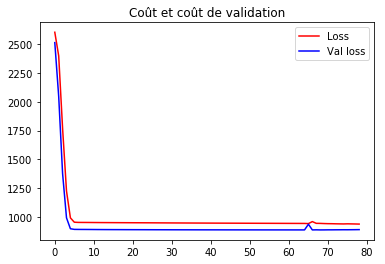

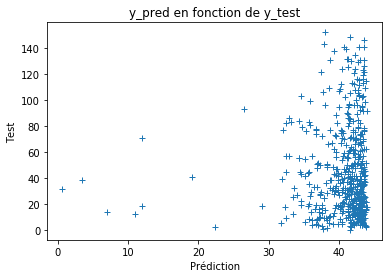

In [12]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [13]:
model = gru_model(32, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                3936      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [14]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

Train on 1103 samples, validate on 539 samples
Epoch 1/5000
1103/1103 [==============================] - 1s 1ms/step - loss: 2605.0681 - val_loss: 2531.0498
Epoch 2/5000
1103/1103 [==============================] - 0s 328us/step - loss: 2552.8981 - val_loss: 2347.9252
Epoch 3/5000
1103/1103 [==============================] - 0s 332us/step - loss: 1990.8319 - val_loss: 1527.0762
Epoch 4/5000
1103/1103 [==============================] - 0s 327us/step - loss: 1320.8043 - val_loss: 1035.4825
Epoch 5/5000
1103/1103 [==============================] - 0s 326us/step - loss: 1011.5817 - val_loss: 902.8878
Epoch 6/5000
1103/1103 [==============================] - 0s 328us/step - loss: 957.9183 - val_loss: 894.8747
Epoch 7/5000
1103/1103 [==============================] - 0s 329us/step - loss: 955.9760 - val_loss: 894.8449
Epoch 8/5000
1103/1103 [==============================] - 0s 335us/step - loss: 955.9011 - val_loss: 894.8261
Epoch 9/5000
1103/1103 [==============================] - 0s 326us

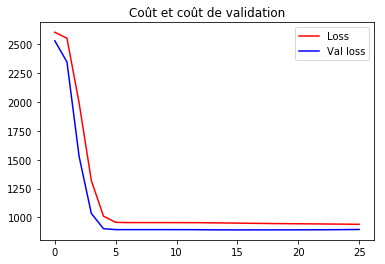

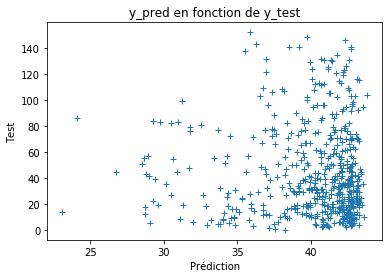

In [15]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()